In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
from scipy.optimize import curve_fit
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
lbv_tics = [279957111,179305185]

In [3]:
def noise_func(f, alpha_0, tau, gamma, alpha_w):
    return alpha_0 / (1.0 + np.power((2.0*np.pi*tau*f),gamma)) + alpha_w

In [4]:
def log_noise(f, alpha_0, tau, gamma, alpha_w):
    return np.log10(noise_func(f, alpha_0, tau, gamma, alpha_w))

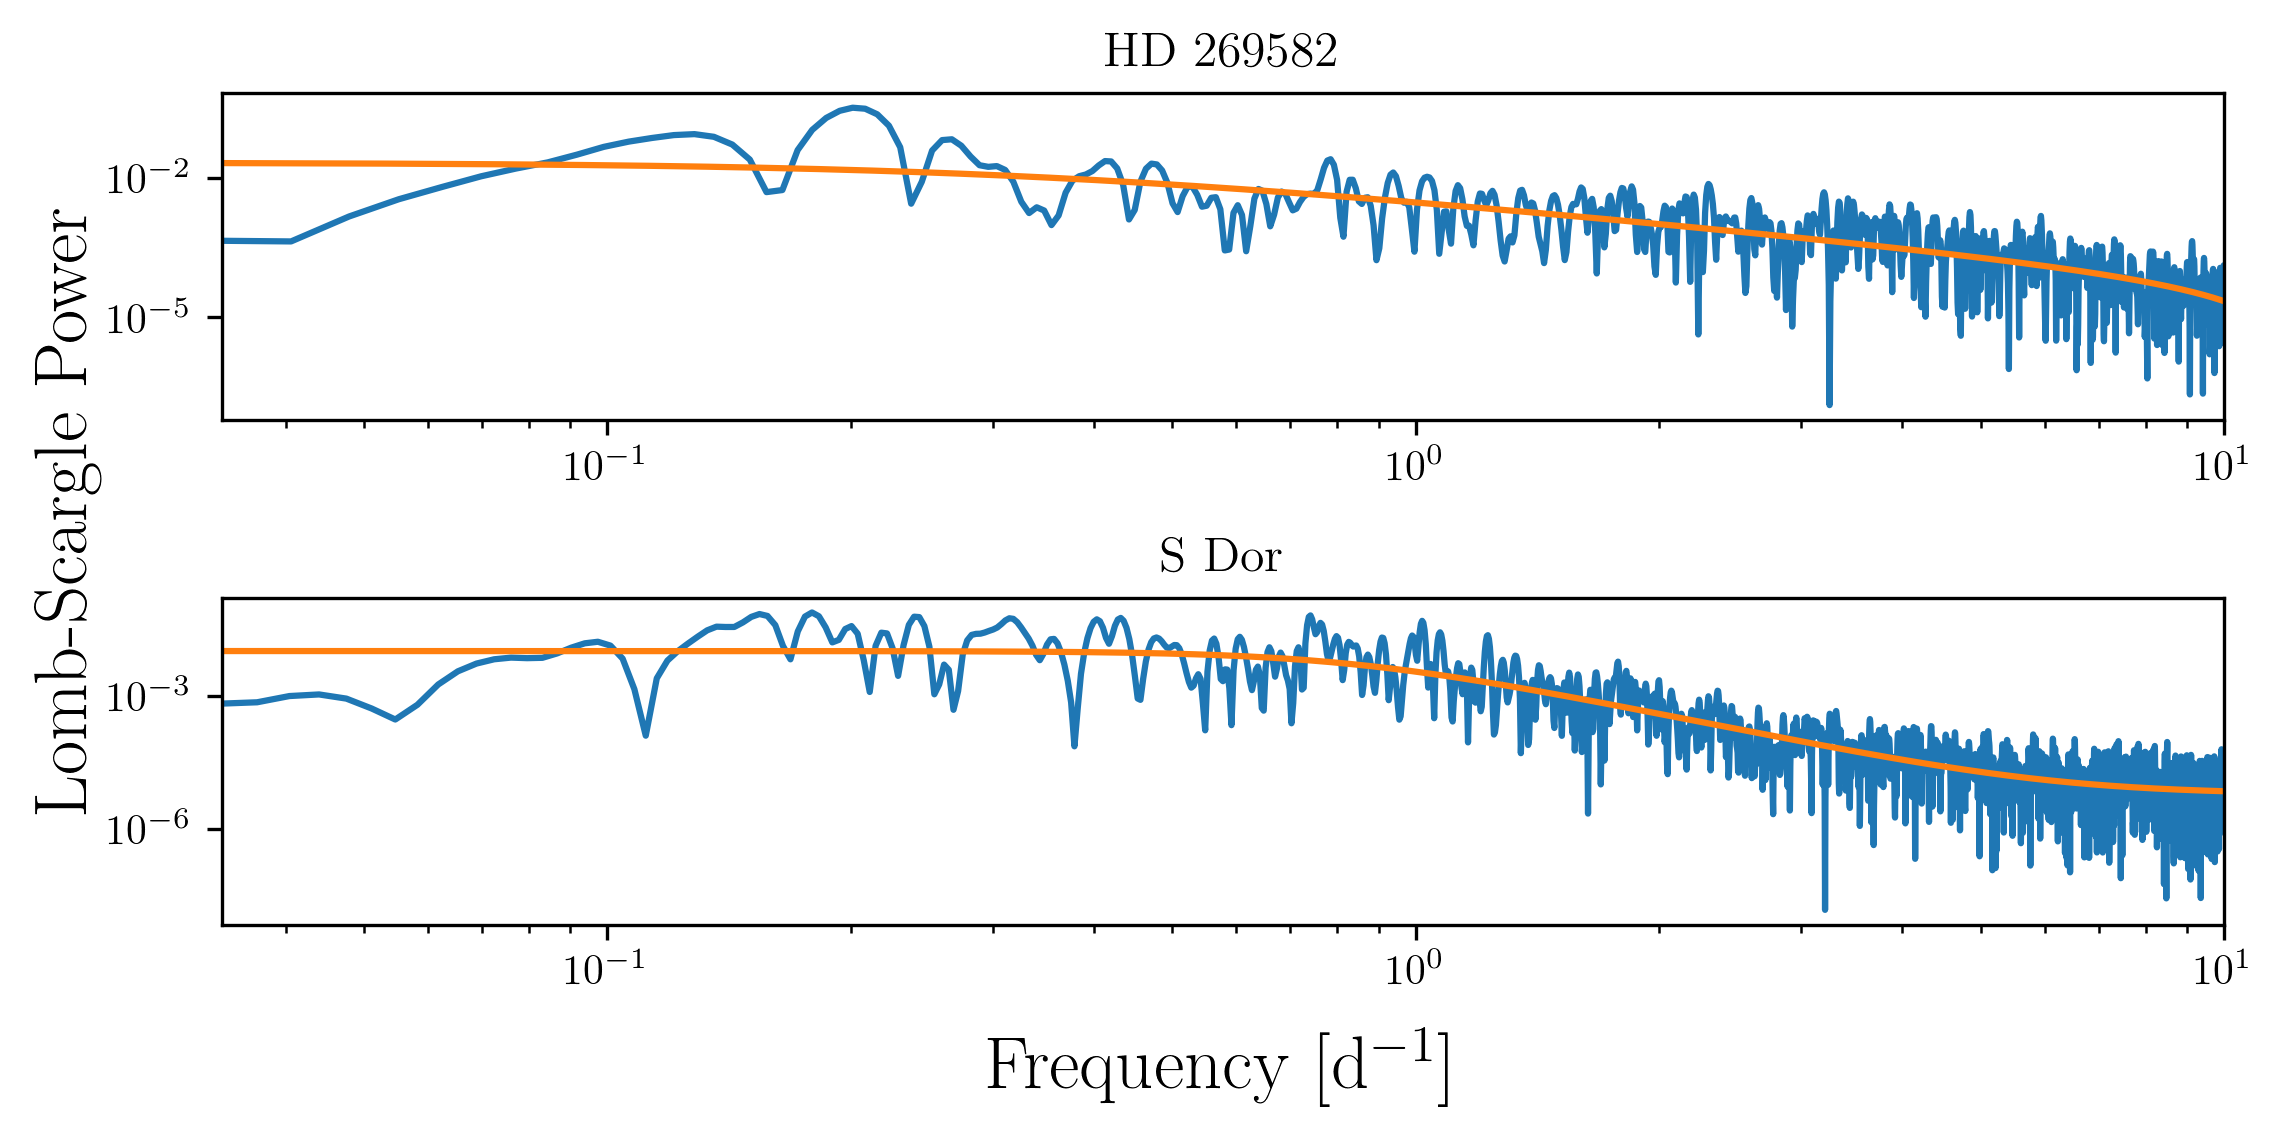

In [7]:
fig, axes = plt.subplots(2, figsize=(8,4),dpi=300)
popts = []
pcovs = []
for i,tid in enumerate(lbv_tics):
    fname = np.unique(massive['CommonName'][massive['ticid']==tid])[0].replace('*','').replace('V','')
    lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
    ax = axes[i]
    time, flux = lc['Time'], lc['Flux']
        
    ls = LombScargle(time, flux)
    f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=1.0/0.1)
    

    p0 = [1e-3, 1.0, 2.0, 1e-5]
    bounds = (-np.inf,np.inf)
        
    popt, pcov = curve_fit(log_noise, f, np.log10(p), bounds=bounds, p0=p0)
    popts.append(popt)
    pcovs.append(pcov)
    ax.loglog(f, p, label='Lomb-Scargle')
    ffit = np.linspace(1.0/30.0,1.0/0.1,1000)
    ax.loglog(ffit,noise_func(ffit,*popt),label='Fit')
    ax.set(title=fname, xlim=(1.0/30.0,1.0/0.1))
    if fname == 'S Dor':
        ax.legend()

    
labax = fig.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
labax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power')
labax.set_zorder(-1)
fig.tight_layout()

labax.xaxis.label.set_size(18)
labax.yaxis.label.set_size(18)
for tick in labax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in labax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.savefig('../plots/lbv_noise_fits.pdf')
popts = np.array(popts)
pcovs = np.array(pcovs)
perrs = np.array([np.sqrt(np.diag(pcov)) for pcov in pcovs])

In [8]:
for pars,errs in zip(popts,perrs):
    print('${0:.2f}\pm{1:.2f}$ & ${2:.2f}\pm{3:.2f}$ & ${4:.2f}\pm{5:.2f}$ & ${6:.2f}\pm{7:.2f}$ \\\\'.format(pars[0]/1e-4,errs[0]/1e-4,pars[1]/1e-2,errs[1]/1e-2,pars[2],errs[2],pars[3]/1e-5,errs[3]/1e-5).replace('e','\\times10^{'))

$218.17\pm64.89$ & $47.94\pm14.01$ & $1.64\pm0.11$ & $-5.92\pm1.48$ \\
$101.59\pm10.32$ & $18.94\pm0.96$ & $3.73\pm0.10$ & $0.61\pm0.05$ \\
